In [37]:
# =============================
# 1. Imports and Setup
# =============================
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tifffile import imread
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import umap.umap_ as umap
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from scipy.spatial.distance import cdist
from sklearn.metrics import ConfusionMatrixDisplay


from torchvision.models import densenet121
import torchvision.transforms as transforms

In [4]:
# =============================
# 2. Load Image Metadata
# =============================
crop_dir = "/home/amtissot/Desktop/LIMNC/hologram_dataset_ML_project/campaigns/training_data_NN_dated/rois_crops"  # <-- UPDATE THIS
csv_path = "/home/amtissot/Desktop/LIMNC/hologram_dataset_ML_project/campaigns/training_data_NN_dated/rois_labels_nn.csv"  # <-- optional, for label inclusion
output_csv = "/home/amtissot/Desktop/LIMNC/hologram_dataset_ML_project/campaigns/training_data_NN_dated/features_deep_densenet.csv"

df_meta = pd.read_csv(csv_path)


In [7]:
# =============================
# 3. Load Pretrained DenseNet and Setup Feature Extractor
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = densenet121(pretrained=True).to(device)
model.eval()

# Remove classifier head and add pooling
feature_extractor = torch.nn.Sequential(*list(model.features.children()))
feature_extractor.add_module("global_avg_pool", torch.nn.AdaptiveAvgPool2d((1, 1)))


/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGEN

In [8]:
# =============================
# 4. Define Preprocessing
# =============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
# =============================
# 5. Extract Features for All ROIs
# =============================
feature_dicts = []

for fname in tqdm(sorted(os.listdir(crop_dir))):
    if not fname.endswith(".tiff"):
        continue

    try:
        img = imread(os.path.join(crop_dir, fname))
        img_rgb = np.stack([img] * 3, axis=-1)
        pil_img = Image.fromarray(img_rgb.astype(np.uint8))

        input_tensor = transform(pil_img).unsqueeze(0).to(device)

        with torch.no_grad():
            features = feature_extractor(input_tensor).squeeze().cpu().numpy().flatten()

        entry = {"filename": fname}
        for i, val in enumerate(features):
            entry[f"feat_{i+1}"] = val

        match = df_meta[df_meta["filename"].apply(lambda x: x in fname)]
        if not match.empty:
            entry["label"] = match.iloc[0]["label"]

        feature_dicts.append(entry)

    except Exception as e:
        print(f"Error processing {fname}: {e}")

# Save features
df_out = pd.DataFrame(feature_dicts)
df_out.to_csv(output_csv, index=False)

100%|██████████| 4794/4794 [03:05<00:00, 25.79it/s]


In [10]:
# =============================
# 6. Feature Preprocessing
# =============================
feature_cols = [col for col in df_out.columns if col.startswith("feat_")]
X = df_out[feature_cols].values
y = df_out['label'].values
filenames = df_out['filename']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


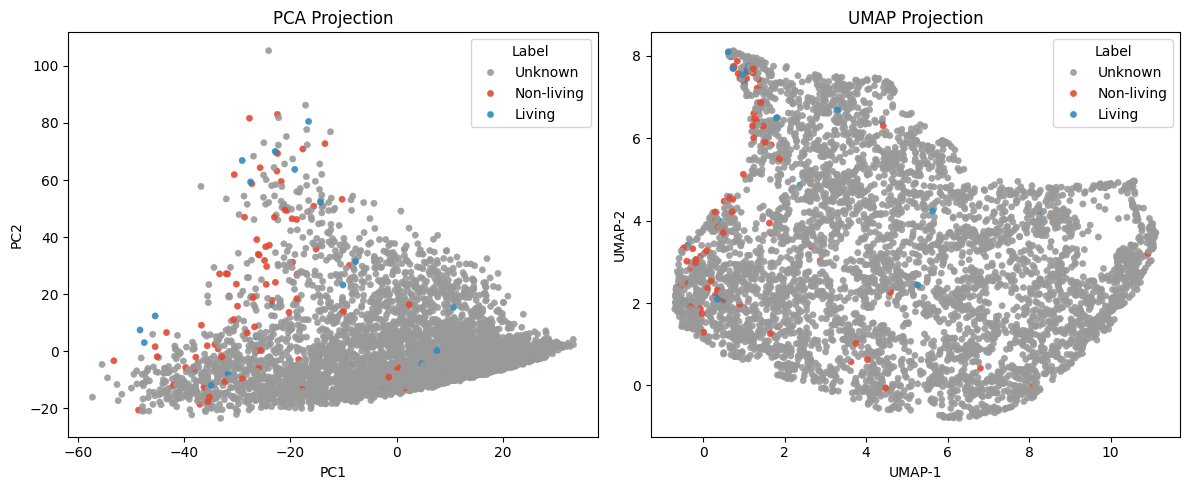

In [41]:
# =============================
# 7. PCA + UMAP Visualization
# =============================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# Set color palette for clearer differentiation
palette = {
    'Unknown': '#999999',         # grey
    'Non-living': '#E24A33',      # strong red
    'Living': '#348ABD'           # strong blue
}

plt.figure(figsize=(12, 5))

# PCA Plot
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=y, palette=palette, s=20, alpha=0.9, edgecolor=None
)
plt.title("PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Label", loc='best')

# UMAP Plot
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=X_umap[:, 0], y=X_umap[:, 1],
    hue=y, palette=palette, s=20, alpha=0.9, edgecolor=None
)
plt.title("UMAP Projection")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Label", loc='best')

plt.tight_layout()
plt.savefig("pca_umap_NN_visualisation.png", dpi=300)
plt.show()

In [22]:
# =============================
# 8. Train/Test Split and Class Balancing
# =============================
df_filtered = df_out[df_out['label'].isin(['Living', 'Non-living'])].copy()
df_filtered['label_binary'] = (df_filtered['label'] == 'Living').astype(int)

X_filtered = scaler.fit_transform(df_filtered[feature_cols])
y_filtered = df_filtered['label_binary'].values

# Compute explained variance to determine number of components
pca_full = PCA()
pca_full.fit(X_filtered)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components to reach 90%
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to reach 90% variance: {n_components_90}")


pca_90 = PCA(n_components=0.9)
X_pca_90 = pca_90.fit_transform(X_filtered)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca_90, y_filtered, test_size=0.4, stratify=y_filtered, random_state=42)

# Aüpply oversampling on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply undersampling on training data
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

Number of components to reach 90% variance: 24


In [23]:
print("Class distribution:\n", pd.Series(y_filtered).value_counts().rename(index={0: "Non-living", 1: "Living"}))

Class distribution:
 Non-living    86
Living        23
Name: count, dtype: int64


In [ ]:
# =============================
# 9. Train Random Forest classifiers
# =============================
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf_rf.fit(X_train, y_train)

clf_rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf_smote.fit(X_train_smote, y_train_smote)

clf_rf_under = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf_under.fit(X_train_under, y_train_under)

RandomForestClassifier(random_state=42)

In [ ]:
# =============================
# 10. Evaluate Random Forest Classifier
# =============================
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_smote = clf_rf_smote.predict(X_test)
y_pred_rf_under = clf_rf_under.predict(X_test)

print("Random Forest")
print(classification_report(y_test, y_pred_rf))

print("Random Forest with SMOTE")
print(classification_report(y_test, y_pred_rf_smote))

print("Random Forest with Undersampling")
print(classification_report(y_test, y_pred_rf_under))

Random Forest
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        35
           1       0.00      0.00      0.00         9

    accuracy                           0.80        44
   macro avg       0.40      0.50      0.44        44
weighted avg       0.63      0.80      0.70        44

Random Forest with SMOTE
              precision    recall  f1-score   support

           0       0.77      0.86      0.81        35
           1       0.00      0.00      0.00         9

    accuracy                           0.68        44
   macro avg       0.38      0.43      0.41        44
weighted avg       0.61      0.68      0.64        44

Random Forest with Undersampling
              precision    recall  f1-score   support

           0       0.85      0.66      0.74        35
           1       0.29      0.56      0.38         9

    accuracy                           0.64        44
   macro avg       0.57      0.61      0.56        44
we

/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [ ]:
# =============================
# 11. Train and Evaluate XGB classifiers
# =============================

clf_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train, y_train)
y_pred_xgb = clf_xgb.predict(X_test)

print("\nXGBoost")
print(classification_report(y_test, y_pred_xgb))

# With SMOTE
clf_xgb_smote = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
clf_xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_xgb_smote = clf_xgb_smote.predict(X_test)

print("\nXGBoost with SMOTE")
print(classification_report(y_test, y_pred_xgb_smote))

# Undersampling
clf_xgb_under = XGBClassifier(n_estimators=100, random_state=42)
clf_xgb_under.fit(X_train_under, y_train_under)
y_pred_rf_under = clf_xgb_under.predict(X_test)

print("\nRandom Forest with Undersampling")
print(classification_report(y_test, y_pred_rf_under))


XGBoost
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        35
           1       0.20      0.11      0.14         9

    accuracy                           0.73        44
   macro avg       0.50      0.50      0.49        44
weighted avg       0.67      0.73      0.70        44


XGBoost with SMOTE
              precision    recall  f1-score   support

           0       0.78      0.83      0.81        35
           1       0.14      0.11      0.12         9

    accuracy                           0.68        44
   macro avg       0.46      0.47      0.47        44
weighted avg       0.65      0.68      0.67        44


Random Forest with Undersampling
              precision    recall  f1-score   support

           0       0.79      0.63      0.70        35
           1       0.19      0.33      0.24         9

    accuracy                           0.57        44
   macro avg       0.49      0.48      0.47        44
weighted av

/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:03:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:03:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [31]:
# =============================
# 12. Train LGBM classifiers
# =============================

clf_lgbm = LGBMClassifier(random_state=42, n_estimators=100)
clf_lgbm.fit(X_train, y_train)
y_pred_lgbm = clf_lgbm.predict(X_test)

print("\nLightGBM")
print(classification_report(y_test, y_pred_lgbm))

clf_lgbm_smote = LGBMClassifier(random_state=42, n_estimators=100)
clf_lgbm_smote.fit(X_train_smote, y_train_smote)
y_pred_lgbm_smote = clf_lgbm_smote.predict(X_test)

print("\nLightGBM with SMOTE")
print(classification_report(y_test, y_pred_lgbm_smote))

clf_lgbm_under = LGBMClassifier(random_state=42, n_estimators=100)
clf_lgbm_under.fit(X_train_under, y_train_under)
y_pred_lgbm_under = clf_lgbm_under.predict(X_test)

print("\nLightGBM with Undersampling")
print(classification_report(y_test, y_pred_lgbm_under))


[LightGBM] [Info] Number of positive: 14, number of negative: 51
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 65, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215385 -> initscore=-1.292768
[LightGBM] [Info] Start training from score -1.292768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

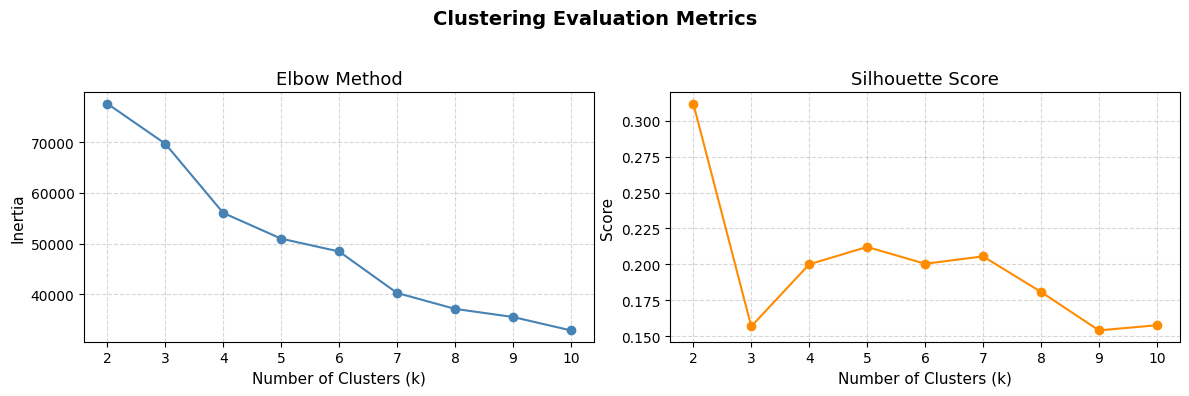

In [40]:
# =============================
# 13. Optional: Clustering with Elbow and Silhouette
# =============================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def plot_elbow_silhouette(X, max_k=10):
    inertia = []
    sil_scores = []

    k_range = range(2, max_k + 1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
        sil_scores.append(silhouette_score(X, labels))

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Elbow Plot
    axs[0].plot(k_range, inertia, marker='o', color='steelblue')
    axs[0].set_title("Elbow Method", fontsize=13)
    axs[0].set_xlabel("Number of Clusters (k)", fontsize=11)
    axs[0].set_ylabel("Inertia", fontsize=11)
    axs[0].grid(True, linestyle='--', alpha=0.5)

    # Silhouette Score Plot
    axs[1].plot(k_range, sil_scores, marker='o', color='darkorange')
    axs[1].set_title("Silhouette Score", fontsize=13)
    axs[1].set_xlabel("Number of Clusters (k)", fontsize=11)
    axs[1].set_ylabel("Score", fontsize=11)
    axs[1].grid(True, linestyle='--', alpha=0.5)

    plt.suptitle("Clustering Evaluation Metrics", fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("figures/clustering_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()

# Run clustering analysis if desired
plot_elbow_silhouette(X_pca_90)


/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


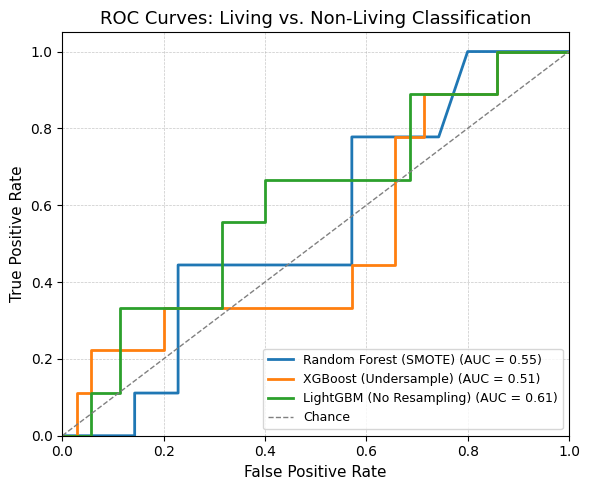

In [ ]:
# =============================
# 14. ROC AUC Curves for Classification
# =============================

def plot_roc_curve(clf, X_test, y_test, label="Model"):
    """
    Plot ROC curve for a binary classifier.

    Parameters:
    - clf: trained classifier with .predict_proba()
    - X_test: test features
    - y_test: true labels
    - label: label for the curve in the plot
    """
    y_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    return fpr, tpr, roc_auc
plt.figure(figsize=(6, 5))

# Curves
plot_roc_curve(clf_rf_smote, X_test, y_test, label="Random Forest (SMOTE)")
plot_roc_curve(clf_xgb_under, X_test, y_test, label="XGBoost (Undersample)")
plot_roc_curve(clf_lgbm, X_test, y_test, label="LightGBM (No Resampling)")

# Chance line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance')

# Axes labels and limits
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curves: Living vs. Non-Living Classification', fontsize=13)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Legend
plt.legend(loc='lower right', fontsize=9, frameon=True)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("figures/ROC_NN.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# =============================
# 14. Intra- and Inter-Class Distances
# =============================

def compute_inter_intra_class_dists(X, y):
    X_0 = X[y == 0]
    X_1 = X[y == 1]

    intra_0 = np.mean(cdist(X_0, X_0))
    intra_1 = np.mean(cdist(X_1, X_1))
    inter = np.mean(cdist(X_0, X_1))

    print(f"Intra-class distance (Non-Living): {intra_0:.2f}")
    print(f"Intra-class distance (Living):     {intra_1:.2f}")
    print(f"Inter-class distance:              {inter:.2f}")
    
compute_inter_intra_class_dists(X_pca_90, y_filtered)

Intra-class distance (Non-Living): 35.03
Intra-class distance (Living):     48.78
Inter-class distance:              43.45


/home/amtissot/miniconda3/envs/dinov2_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


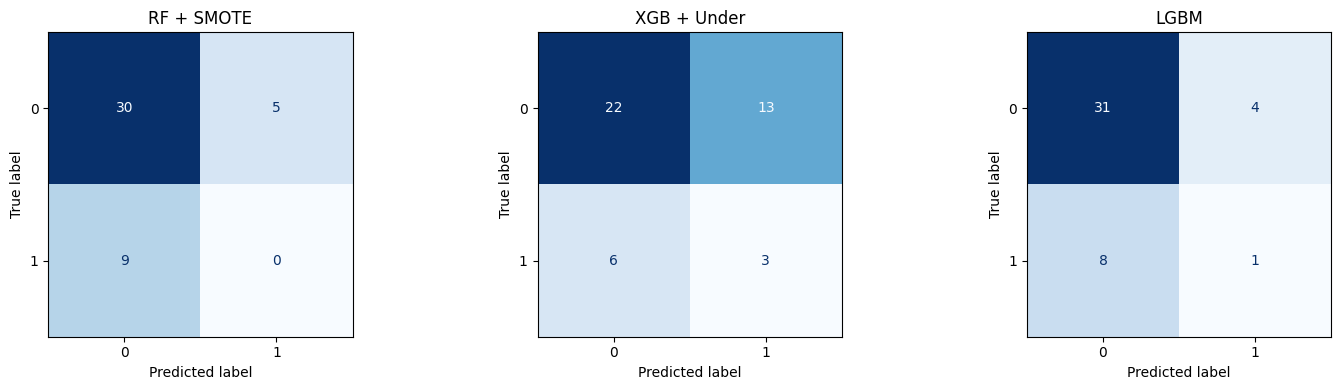

In [ ]:
# =============================
# 15. Confusion Matrices
# =============================

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

models = [
    ("RF + SMOTE", clf_rf_smote),
    ("XGB + Under", clf_xgb_under),
    ("LGBM", clf_lgbm),
]

for ax, (label, clf) in zip(axs, models):
    ConfusionMatrixDisplay.from_estimator(
        clf, X_test, y_test, cmap="Blues", ax=ax, colorbar=False
    )
    ax.set_title(label)

plt.tight_layout()
plt.show()